### Generate data options
option 1: generate data by using the op and cp range
         - combine data of the op range and determine if there is a cp output
option 2: have a range for every record 
         - example: 1. looks at record+1 and if record within time range is true then identiyf whether it is a churned user.

In [32]:
import pandas as pd
import numpy as np
import json
from IPython.display import display
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import clone
import os
from sklearn.metrics import  accuracy_score,classification_report,roc_auc_score,log_loss,zero_one_loss,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.grid_search import RandomizedSearchCV

#method used to display in a plot the important features from a model
def feature_plot(imp_features,X):
    indices = np.argsort(imp_features)[::-1]
    num_features=len(imp_features[imp_features>0])
    columns = X.columns.values[indices][:num_features]
    values=imp_features[indices][:num_features]

    plt.figure(figsize = (15,5))
    plt.title("Feature importances")
    plt.barh(range(num_features), values, align="center")
    plt.yticks(range(num_features), columns)
    plt.ylim([ num_features,-1])
    plt.show() 
    
#method used to evaluate and score our models.
#returns a list of 3 metrics used.
def classification_metric(y_true,y_predict):
    acc=accuracy_score(y_true,y_predict.round())
    roc_auc=roc_auc_score(y_true, y_predict.round())
    zero_one=zero_one_loss(y_true,y_predict.round())
    print('accuracy score',acc)
    print('roc_auc_score',roc_auc)
    print('log loss score',log_loss(y_true,y_predict))
    print('zero_one_loss score',zero_one)
    print('confusion_matrix',confusion_matrix(y_true,y_predict.round()))
    print(classification_report(y_true,y_predict.round()))
    
    return [roc_auc,zero_one,acc]
    
#method used to read the preprocessed raw file
#returns the data read as a dataframe
def get_preproc_data(include_team=False):
    if include_team:
        preprocessed_data=pickle.load(open('processed_raw_data_with_team.p', "rb" ))
    else:
        preprocessed_data=pickle.load(open('processed_raw_data.p', "rb" ))
        
    return preprocessed_data

#method used to filter(keep) columns from our data
#returns dataframe with only the specified columns
def filter_columns(data,columns,to_filter=True):
    if to_filter:
        return data[columns]
    else:
        return data
    
#method used to scale the inputs
#returns dataframe with scaled columns
def scale_numerical_data(data,scale=False):
    if scale: 
        scaler=StandardScaler()
        columns_to_encode=list(data.select_dtypes(include=['float64','int64']))
        columns_to_encode.remove('churned')

        features_transform = pd.DataFrame(data = data)
        features_transform[columns_to_encode] = scaler.fit_transform(data[columns_to_encode])
        return features_transform
    else:
        return data
    
#method used to summarize input data, append summzaried fields to a list
#returns a list with summarized (row)values, and column name list
def get_field_summary(data,new_data,columns_to_add,include_team=False):
    #total_games_played
    columns_to_add.append('games_played')
    games_played=data.shape[0]
    new_data.append(games_played)
    
    #min_score
    columns_to_add.append('min_score')
    new_data.append(data['player_score'].min())
    #mean_score
    columns_to_add.append('mean_score')
    new_data.append(data['player_score'].mean())
    #max_score
    columns_to_add.append('max_score')
    new_data.append(data['player_score'].max())
    #sd_score
    columns_to_add.append('sd_score')
    new_data.append(data['player_score'].std())
    
    #score_ratio
    columns_to_add.append('score_ratio')
    new_data.append(data['player_score'].sum()/games_played)
    

    #SECONDS,total_time_played
    columns_to_add.append('total_time_played')
    new_data.append(data['duration'].sum()/60)
    
    #avg_game_duration(seconds)
    columns_to_add.append('avg_game_duration')
    new_data.append(data['duration'].mean()/60)
    #max_duration
    columns_to_add.append('max_game_duration')
    new_data.append(data['duration'].max()/60)
    #min_duration
    columns_to_add.append('min_game_duration')
    new_data.append(data['duration'].min()/60)
    
    #avg_player_degree(~~??)
    columns_to_add.append('avg_player_degree')
    new_data.append(data['player_degree'].mean())
    #max_player_degree
    columns_to_add.append('max_player_degree')
    new_data.append(data['player_degree'].max())
    #min_player_degree
    columns_to_add.append('min_player_degree')
    new_data.append(data['player_degree'].min())
    
    #avg_player_points(rank)
    columns_to_add.append('avg_player_rank')
    new_data.append(data['player_points'].mean())
    #min_player_points(rank)
    columns_to_add.append('min_player_rank')
    new_data.append(data['player_points'].min())
    #max_player_points(rank)
    columns_to_add.append('max_player_rank')
    new_data.append(data['player_points'].max())
   
    #avg_dist_visit
    columns_to_add.append('avg_dist_bw_visit')
    distance_data=data['date'].diff().dt.total_seconds()
    #avg_dist_visit=data['date'].diff().dt.total_seconds().mean()
    avg_dist_visit=distance_data.mean()
    avg_dist_visit/=60
    new_data.append(0 if np.isnan(avg_dist_visit) else avg_dist_visit)
    #max_dist_visit
    columns_to_add.append('max_dist_bw_visit')
    max_dist_visit=distance_data.max()
    max_dist_visit/=60
    new_data.append(0 if np.isnan(max_dist_visit) else max_dist_visit)
    #min_dist_visit
    columns_to_add.append('min_dist_bw_visit')
    min_dist_visit=distance_data.min()
    min_dist_visit/=60
    new_data.append(0 if np.isnan(min_dist_visit) else min_dist_visit)    
    #std_dist_visit
    columns_to_add.append('std_dist_bw_visit')
    std_dist_visit=distance_data.std()
    std_dist_visit/=60
    new_data.append(0 if np.isnan(std_dist_visit) else std_dist_visit)
    
    
    if include_team:
        #games won
        columns_to_add.append('games_won')
        new_data.append(data['win'].sum())
        #win_ratio
        columns_to_add.append('win_ratio')
        new_data.append(data['win'].sum()/games_played)
        

    return new_data,columns_to_add

#Method used to generate summary data for every player in our data
#returns summarized dataframe
def gen_clf_data(op=5,cp=10,include_team=False):
    data=get_preproc_data(include_team)
    new_data=[]
    for x in tqdm(data['player_name'].unique()):
        player_data=data.loc[data['player_name']==x]
        
        op_min_date=player_data['date'].min()
        op_max_date=op_min_date+ pd.DateOffset(days=op)
        cp_max_date=op_max_date+ pd.DateOffset(days=cp)
        
        col_names= ['player','churned']
        op_data=player_data.loc[(player_data['date'] >= op_min_date) & (player_data['date'] <= op_max_date)]
        cp_data=player_data.loc[(player_data['date'] > op_max_date) & (player_data['date'] <= cp_max_date)]
        
        summary_data=[]
        summary_data.append(x)
        summary_data.append(1 if cp_data.empty else 0)
        
        summary,col_names=get_field_summary(op_data,summary_data,col_names,include_team)
        

        
        new_data.append(summary)
        #display(player_data)
    #data_frame=pd.DataFrame(new_data,columns=col_names)
        
    return pd.DataFrame(new_data,columns=col_names)

#method used to retrieve saved summary data or create the summary data
#returns data train and test dataframe.
def get_clf_data(op,cp,include_team,filter_data,columns_to_keep,scale_data):
    name='clf_data_op_'+str(op)+'_'+str(cp)+'_team_'+str(include_team)+'.p'
    if os.path.isfile(name):
        data=pickle.load(open(name,'rb'))
    else:
        data=gen_clf_data(op,cp,include_team)
        pickle.dump(data,open(name, "wb" ))
        
    data=filter_columns(data,columns_to_keep,filter_data)
    data=scale_numerical_data(data,scale_data)
    data=data.fillna(0)
    X=data.drop(['churned','player'],axis=1)
    y=data['churned']
    return X,y

#method used to log our model results
def set_log_data(details,clf_metrics,save=True):
    details.extend(clf_metrics)
    
    if save:
        if os.path.isfile('log_data.csv'):
            df=pd.DataFrame([details])
            df.to_csv('log_data.csv', mode='a', header=False, index=False)
        else:
            column_names=['model','op','cp','bin_time','scaled','batch_size','epochs'
                     ,'with_team','kfold','roc_auc','zero_one_loss','accuracy']

            df=pd.DataFrame(data=[details],columns=column_names)
            df.to_csv('log_data.csv', header=True, index=False)
#method used to read our log data
#returns the log dataframe
def read_log_data():
    if os.path.isfile('log_data.csv'):
        return pd.read_csv('log_data.csv')
    else:
        return None
#method used to train and test specified models
#returns the feature importance of the last model
def get_classification_results(X_train,y_train,X_test,y_test,clf_models,details,print_var_imp):
    imp_features=None
    for clf in clf_models:
        model_name=clf.__class__.__name__
        print('classifier: ',model_name)
        clf.fit(X_train,y_train)
        pred=clf.predict(X_test)
        
        column_data=[model_name]
        column_data.extend(details)
        clf_metrics=classification_metric(y_test,pred)
        set_log_data(column_data,clf_metrics)
        if print_var_imp:
            try:
                imp_features=clf.feature_importances_
                feature_plot(imp_features,X_train)  
            except AttributeError:
                pass
    return imp_features

#method used to display the correlation of values to our churned dataset.
def plot_corr_plot(X,y):
    X['churned']=y
    data=X
    #data=
    corr = data.corr()
    churn_corr=corr.sort_values('churned',ascending=True)
    churn_corr=churn_corr['churned']
    churn_corr.plot('barh')
    plt.show();
#method used to make a random search of our model based on the specified param list
#returns model that yields the best result
def random_search_clf(model,param_dist,X_train,y_train,k_fold_num):
    scorer = make_scorer(roc_auc_score)
    random_search = RandomizedSearchCV(model,param_dist,scoring=scorer,random_state=42,n_iter=20,verbose=0)
    random_search.fit(X_train,y_train)
    best_clf = random_search.best_estimator_
    return best_clf

#method used to filter our train and test data based on specified importance values
#returns train and test data with with filtered features
def filter_data_importance(X_train,X_test,importances,kept_features=5):
    X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:kept_features]]]
    X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:kept_features]]]
    return X_train_reduced,X_test_reduced

In [40]:
read_log_data()

model  op  cp  bin_time  scaled  batch_size  epochs  \
0            bi_rnn_norm_model   5  10        30   False         256      25   
1                  bidir_model   5  10        30   False         256      25   
2         rnn_norm_dense_model   5  10        30   False         256      25   
3                    rnn_model   5  10        30   False         256      25   
4      bi_rnn_norm_dense_model   5  10        30   False         256      25   
5       rnn_norm_2_dense_model   5  10        30   False         256      25   
6            bi_rnn_norm_model   4   7        30   False         256      25   
7                  bidir_model   4   7        30   False         256      25   
8         rnn_norm_dense_model   4   7        30   False         256      25   
9            bi_rnn_norm_model   4   4        30   False         256      25   
10                 bidir_model   4   4        30   False         256      25   
11        rnn_norm_dense_model   4   4        30   False         256      25   
12           bi_rnn_norm_model   7  14        30   False         256      25   
13                 bidir_model   7  14        30   False         256      25   
14          LogisticRegression   5  10         0   False           0       0   
15      RandomForestClassifier   5  10         0   False           0       0   
16  GradientBoostingClassifier   5  10         0   False           0       0   
17        rnn_norm_dense_model   7  14        30   False         256      25   
18           bi_rnn_norm_model  15  15        30   False         256      25   
19                 bidir_model  15  15        30   False         256      25   
20        rnn_norm_dense_model  15  15        30   False         256      25   
21           bi_rnn_norm_model  15  15        60   False         256      25   
22        rnn_norm_dense_model  15  15        60   False         256      25   
23                 bidir_model  15  15        60   False         256      25   
24           bi_rnn_norm_model  15  15        10   False          64      25   
25        rnn_norm_dense_model  15  15        10   False          64      25   
26           bi_rnn_norm_model  15  15        30    True         256      25   
27           bi_rnn_norm_model  15  15        30    True         256      25   
28  GradientBoostingClassifier   5  10         0   False           0       0   
29           bi_rnn_norm_model  15  30        30   False         256      25   
..                         ...  ..  ..       ...     ...         ...     ...   
32                 bidir_model  15  30        30   False         256      25   
33          LogisticRegression   5  10         0   False           0       0   
34      RandomForestClassifier   5  10         0   False           0       0   
35  GradientBoostingClassifier   5  10         0   False           0       0   
36          LogisticRegression   5  10         0   False           0       0   
37      RandomForestClassifier   5  10         0   False           0       0   
38  GradientBoostingClassifier   5  10         0   False           0       0   
39  GradientBoostingClassifier   5  10         0   False           0       0   
40           bi_rnn_norm_model   4   7        10   False         256      25   
41  GradientBoostingClassifier   5  10         0   False           0       0   
42  GradientBoostingClassifier   5  10         0   False           0       0   
43        rnn_norm_dense_model   4   7        10   False         256      25   
44                 bidir_model   4   7        10   False         256      25   
45                   rnn_model   4   7        10   False         256      25   
46  GradientBoostingClassifier   5  10         0   False           0       0   
47  GradientBoostingClassifier   5  10         0   False           0       0   
48           bi_rnn_norm_model   4   3        30   False         256      25   
49        rnn_norm_dense_model   4   3        30   False         256      25   
50                 bidir_

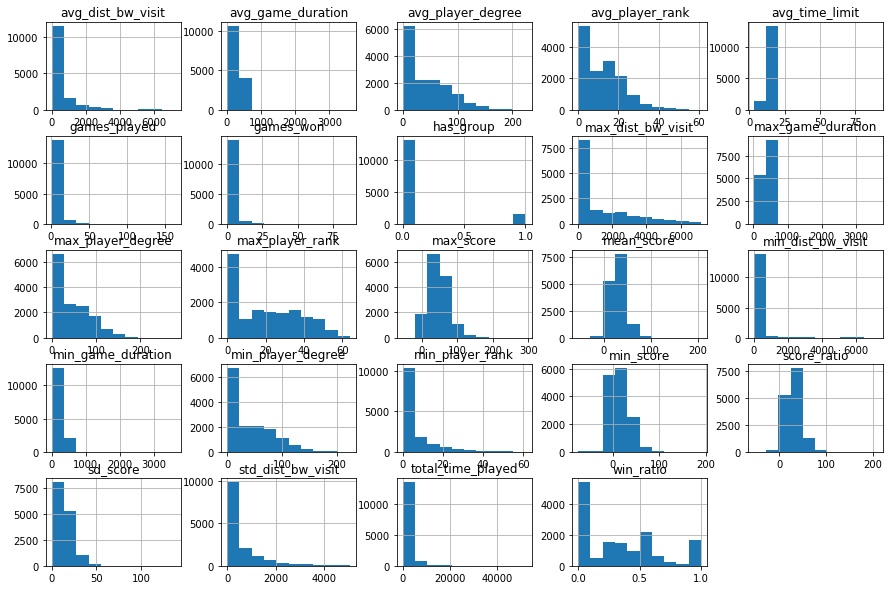

In [30]:
X.hist(figsize=(15,10));

## Immediate Churners

### Loading data and setting parameters

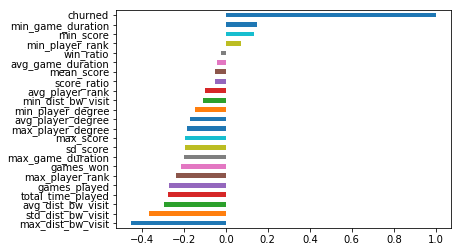

x_train 11703 x_test 2926


games_played  min_score  mean_score  max_score   sd_score  score_ratio  \
0             1         19        19.0         19   0.000000         19.0   
1             1         50        50.0         50   0.000000         50.0   
2             4         31        40.0         56  11.165423         40.0   

   total_time_played  avg_game_duration  max_game_duration  min_game_duration  \
0         376.033333         376.033333         376.033333         376.033333   
1         376.033333         376.033333         376.033333         376.033333   
2        1479.100000         369.775000         720.116667         137.816667   

     ...      min_player_degree  avg_player_rank  min_player_rank  \
0    ...                     31             29.0               29   
1    ...                     89             31.0               31   
2    ...                      0              0.0                0   

   max_player_rank  avg_dist_bw_visit  max_dist_bw_visit  min_dist_bw_visit  \
0               29           0.000000               0.00           0.000000   
1               31           0.000000               0.00           0.000000   
2                0         493.527778            1457.45          10.333333   

   std_dist_bw_visit  games_won  win_ratio  
0           0.000000        1.0        1.0  
1           0.000000        1.0        1.0  
2         834.782043        2.0        0.5  

[3 rows x 22 columns]

0    0
1    1
2    0
Name: churned, dtype: int64

In [41]:
random_state=42
op=4
cp=7
k_fold_num=0
filter_data=False
scale_data=False
include_team=True
details=[op,cp,0,scale_data,0,0,include_team,k_fold_num]
columns_to_keep=['mean_score','games_played','total_time_played',
                 'max_player_rank','max_dist_bw_visit','std_dist_bw_visit','max_game_duration'
                  ,'player','churned']
X,y=get_clf_data(op,cp,include_team,filter_data,columns_to_keep,scale_data)
plot_corr_plot(X.copy(),y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_state)
print('x_train',X_train.shape[0], 'x_test',X_test.shape[0])
display(X.head(3))
display(y.head(3))

### Testing different models

classifier:  LogisticRegression
accuracy score 0.7576896787423103
roc_auc_score 0.714667084563655
log loss score 8.36923700106705
zero_one_loss score 0.2423103212576897
confusion_matrix [[ 595  494]
 [ 215 1622]]
             precision    recall  f1-score   support

          0       0.73      0.55      0.63      1089
          1       0.77      0.88      0.82      1837

avg / total       0.75      0.76      0.75      2926

classifier:  RandomForestClassifier
accuracy score 0.7221462747778538
roc_auc_score 0.7033728685878932
log loss score 9.596837815046737
zero_one_loss score 0.27785372522214624
confusion_matrix [[ 686  403]
 [ 410 1427]]
             precision    recall  f1-score   support

          0       0.63      0.63      0.63      1089
          1       0.78      0.78      0.78      1837

avg / total       0.72      0.72      0.72      2926



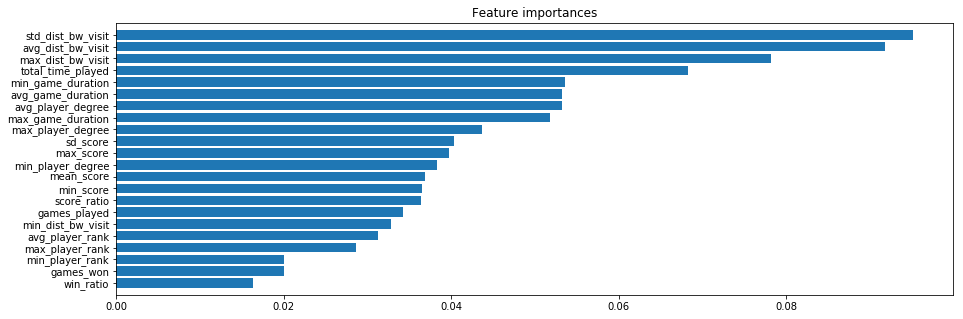

classifier:  GradientBoostingClassifier
accuracy score 0.7665755297334245
roc_auc_score 0.7324002133474098
log loss score 8.062315004033149
zero_one_loss score 0.23342447026657553
confusion_matrix [[ 652  437]
 [ 246 1591]]
             precision    recall  f1-score   support

          0       0.73      0.60      0.66      1089
          1       0.78      0.87      0.82      1837

avg / total       0.76      0.77      0.76      2926



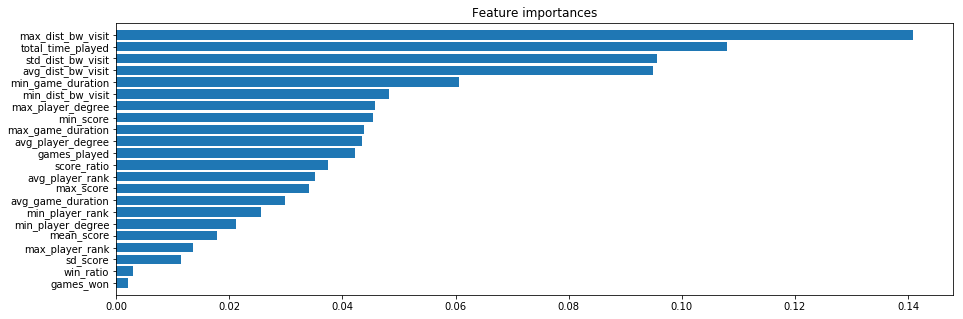

array([0.04225639, 0.04532925, 0.0177377 , 0.03405821, 0.01153829,
       0.03746205, 0.10797426, 0.02977667, 0.04377227, 0.06059993,
       0.04353588, 0.0457108 , 0.02119288, 0.03518739, 0.02557475,
       0.01353436, 0.09490292, 0.14094166, 0.0481477 , 0.09566829,
       0.00211226, 0.0029861 ])

In [42]:
clf_models=[LogisticRegression(),
            RandomForestClassifier(random_state=random_state),
            GradientBoostingClassifier(random_state=random_state)
    ]   
get_classification_results(X_train,y_train,X_test,y_test,clf_models,details,True)

### Random Search Best Model

classifier:  GradientBoostingClassifier
accuracy score 0.7665755297334245
roc_auc_score 0.7352045220853058
log loss score 8.062310904934908
zero_one_loss score 0.23342447026657553
confusion_matrix [[ 667  422]
 [ 261 1576]]
             precision    recall  f1-score   support

          0       0.72      0.61      0.66      1089
          1       0.79      0.86      0.82      1837

avg / total       0.76      0.77      0.76      2926



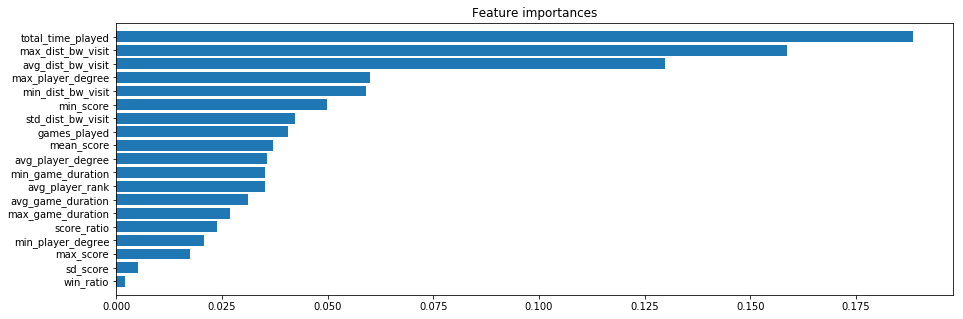

In [43]:
param_dist= {'loss' : ['deviance', 'exponential'] ,'n_estimators': [50, 100,250,500,1000], 'learning_rate': [1.0, 0.5,0.1], 
                           'max_depth': [2,3,4,5,6,7,8,9,10]}
iter_num=20
details=[op,cp,0,scale_data,0,0,include_team,iter_num]
best_model=random_search_clf(GradientBoostingClassifier(random_state=random_state),param_dist,X_train,y_train,iter_num)
importances=get_classification_results(X_train,y_train,X_test,y_test,[best_model],details,True)

### Test the best model with automatic feature selection

Model with reduced feature space
classifier:  GradientBoostingClassifier
accuracy score 0.7655502392344498
roc_auc_score 0.7340140655328462
log loss score 8.097723730765253
zero_one_loss score 0.23444976076555024
confusion_matrix [[ 665  424]
 [ 262 1575]]
             precision    recall  f1-score   support

          0       0.72      0.61      0.66      1089
          1       0.79      0.86      0.82      1837

avg / total       0.76      0.77      0.76      2926



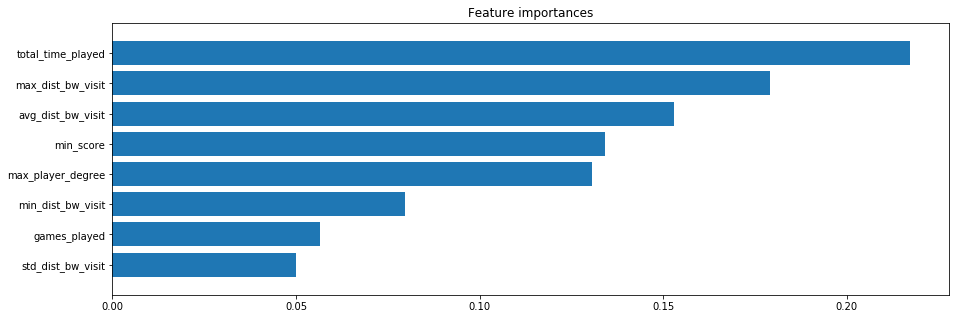

In [44]:
if not filter_data:
    print('Model with reduced feature space')
    X_train_reduced,X_test_reduced=filter_data_importance(X_train,X_test,importances,8)
    get_classification_results(X_train_reduced,y_train,X_test_reduced,y_test,[clone(best_model)],details,True)

## Gradual Churners

### Loading data and setting parameters

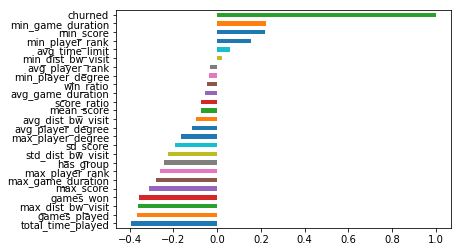

In [45]:
random_state=42
op=15
cp=15
k_fold_num=0
filter_data=False
scale_data=False
include_team=True
details=[op,cp,0,scale_data,0,0,include_team,k_fold_num]
columns_to_keep=['mean_score','games_played','total_time_played',
                 'max_player_rank','max_dist_bw_visit','std_dist_bw_visit','max_game_duration'
                  ,'player','churned']
X,y=get_clf_data(op,cp,include_team,filter_data,columns_to_keep,scale_data)
plot_corr_plot(X.copy(),y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_state)

### Testing different models

classifier:  LogisticRegression
accuracy score 0.8810663021189337
roc_auc_score 0.6437006493666824
log loss score 4.107899273795213
zero_one_loss score 0.11893369788106634
confusion_matrix [[ 127  274]
 [  74 2451]]
             precision    recall  f1-score   support

          0       0.63      0.32      0.42       401
          1       0.90      0.97      0.93      2525

avg / total       0.86      0.88      0.86      2926

classifier:  RandomForestClassifier
accuracy score 0.885850991114149
roc_auc_score 0.7219910619490876
log loss score 3.9426222947987246
zero_one_loss score 0.114149008885851
confusion_matrix [[ 199  202]
 [ 132 2393]]
             precision    recall  f1-score   support

          0       0.60      0.50      0.54       401
          1       0.92      0.95      0.93      2525

avg / total       0.88      0.89      0.88      2926



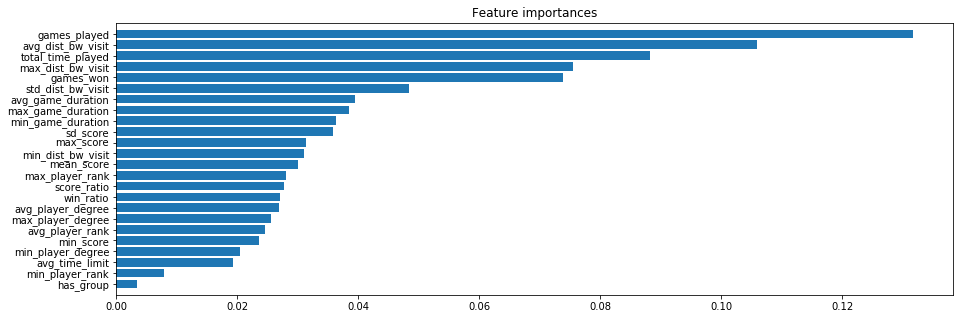

classifier:  GradientBoostingClassifier
accuracy score 0.8998632946001367
roc_auc_score 0.7112303399916051
log loss score 3.4586593968364574
zero_one_loss score 0.1001367053998633
confusion_matrix [[ 181  220]
 [  73 2452]]
             precision    recall  f1-score   support

          0       0.71      0.45      0.55       401
          1       0.92      0.97      0.94      2525

avg / total       0.89      0.90      0.89      2926



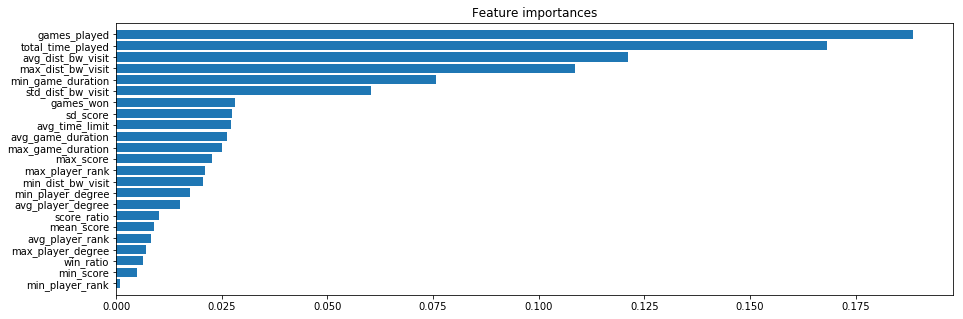

array([0.18868435, 0.00498357, 0.00885024, 0.0226616 , 0.02748705,
       0.01004872, 0.16828126, 0.02623079, 0.02510271, 0.07566646,
       0.01511229, 0.0070521 , 0.01749381, 0.00827819, 0.00093477,
       0.02092139, 0.02722269, 0.12105392, 0.10851246, 0.02061014,
       0.06040912, 0.02803907, 0.00636329, 0.        ])

In [46]:
clf_models=[LogisticRegression(),
            RandomForestClassifier(random_state=random_state),
            GradientBoostingClassifier(random_state=random_state)
    ]   
get_classification_results(X_train,y_train,X_test,y_test,clf_models,details,True)

### Random Search Best Model

classifier:  GradientBoostingClassifier
accuracy score 0.9036226930963773
roc_auc_score 0.7375324066072443
log loss score 3.32880808751147
zero_one_loss score 0.09637730690362267
confusion_matrix [[ 204  197]
 [  85 2440]]
             precision    recall  f1-score   support

          0       0.71      0.51      0.59       401
          1       0.93      0.97      0.95      2525

avg / total       0.90      0.90      0.90      2926



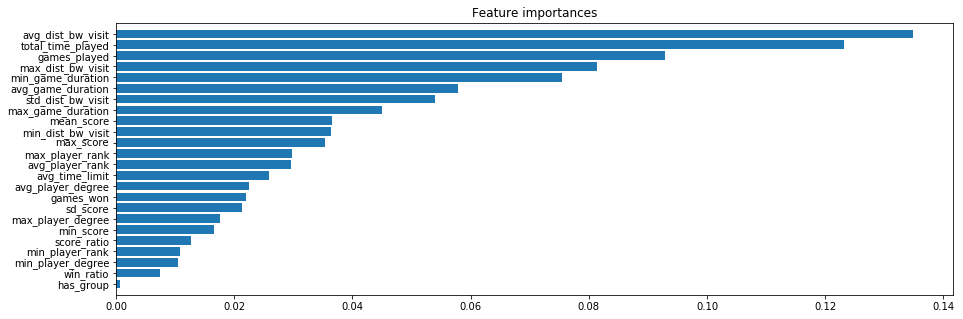

In [47]:
param_dist= {'loss' : ['deviance', 'exponential'] ,'n_estimators': [50, 100,250,500,1000], 'learning_rate': [1.0, 0.5,0.1], 
                           'max_depth': [2,3,4,5,6,7,8,9,10]}
iter_num=20
details=[op,cp,0,scale_data,0,0,include_team,iter_num]
best_model=random_search_clf(GradientBoostingClassifier(random_state=random_state),param_dist,X_train,y_train,iter_num)
importances=get_classification_results(X_train,y_train,X_test,y_test,[best_model],details,True)

### Test the best model with automatic feature selection

Model with reduced feature space
classifier:  GradientBoostingClassifier
accuracy score 0.9043062200956937
roc_auc_score 0.7421238981753537
log loss score 3.305198808229331
zero_one_loss score 0.09569377990430628
confusion_matrix [[ 208  193]
 [  87 2438]]
             precision    recall  f1-score   support

          0       0.71      0.52      0.60       401
          1       0.93      0.97      0.95      2525

avg / total       0.90      0.90      0.90      2926



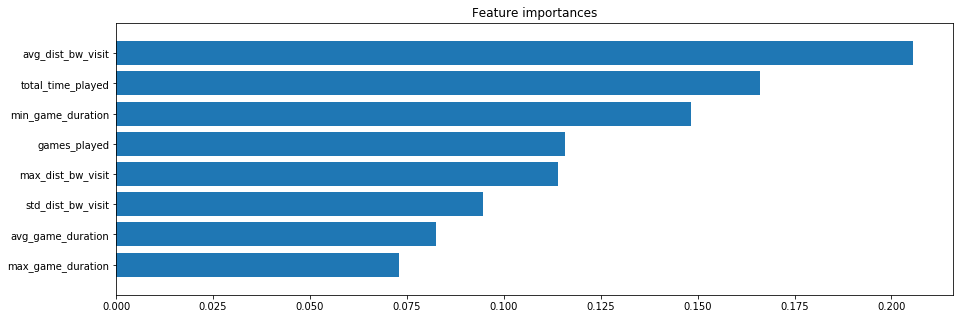

In [48]:
if not filter_data:
    print('Model with reduced feature space')
    X_train_reduced,X_test_reduced=filter_data_importance(X_train,X_test,importances,8)
    get_classification_results(X_train_reduced,y_train,X_test_reduced,y_test,[clone(best_model)],details,True)